In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hourly-energy-consumption/est_hourly.paruqet
/kaggle/input/hourly-energy-consumption/DOM_hourly.csv
/kaggle/input/hourly-energy-consumption/EKPC_hourly.csv
/kaggle/input/hourly-energy-consumption/DUQ_hourly.csv
/kaggle/input/hourly-energy-consumption/DAYTON_hourly.csv
/kaggle/input/hourly-energy-consumption/PJME_hourly.csv
/kaggle/input/hourly-energy-consumption/PJM_Load_hourly.csv
/kaggle/input/hourly-energy-consumption/NI_hourly.csv
/kaggle/input/hourly-energy-consumption/FE_hourly.csv
/kaggle/input/hourly-energy-consumption/COMED_hourly.csv
/kaggle/input/hourly-energy-consumption/AEP_hourly.csv
/kaggle/input/hourly-energy-consumption/pjm_hourly_est.csv
/kaggle/input/hourly-energy-consumption/DEOK_hourly.csv
/kaggle/input/hourly-energy-consumption/PJMW_hourly.csv


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pallete = sns.color_palette()
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [3]:
df = pd.read_csv('../input/hourly-energy-consumption/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [4]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


<AxesSubplot:title={'center':'PJME Energy used in MW'}, xlabel='Datetime'>

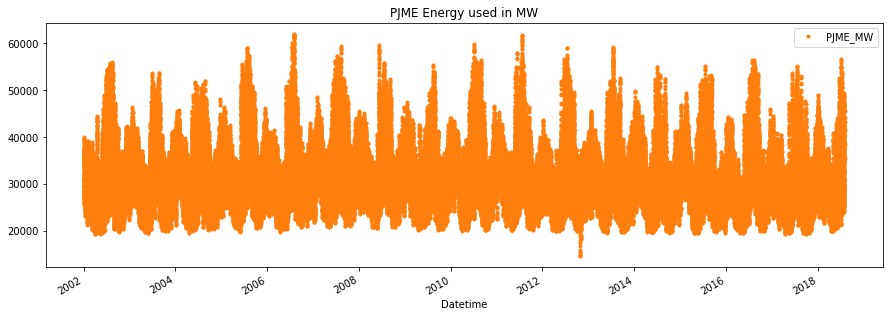

In [5]:
df.plot(style = '.',figsize=(15,5),color = color_pallete[1],title = 'PJME Energy used in MW'       )

## Train Test Split

In [6]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index > '01-01-2015']

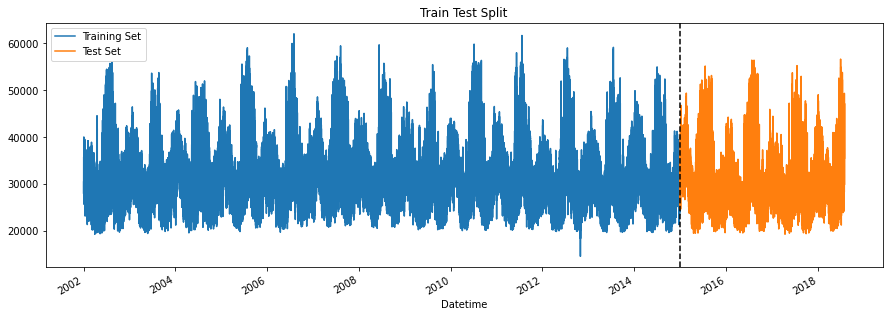

In [7]:
fig, ax = plt.subplots(figsize = (15,5))
train.plot(ax=ax,label = 'Training Set',title = 'Train Test Split')
test.plot(ax=ax, label = 'Test Set')
ax.axvline('01-01-2015',color = 'black',ls = '--')
plt.legend(['Training Set','Test Set'])
plt.show()

<Figure size 1200x800 with 0 Axes>

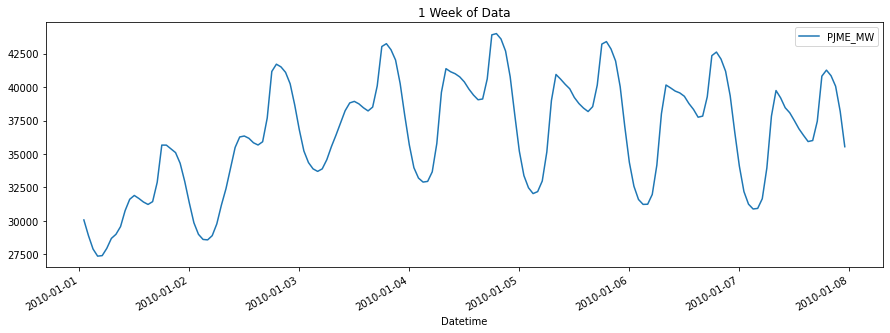

In [8]:
plt.figure(dpi = 200)
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize = (15,5), title = '1 Week of Data')
plt.show()

## Feature Creation

In [9]:
def create_feature(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['day'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear']  = df.index.dayofyear
    return df
df = create_feature(df)

In [10]:
df.head()

,PJME_MW,hour,day,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365


In [11]:
def plot(x,y,df):
    fig, ax = plt.subplots(figsize = (10,8),dpi = 200)
    sns.boxplot(data = df, x = x, y = y)
    ax.set_title(f"MW by {x}")
    plt.show()

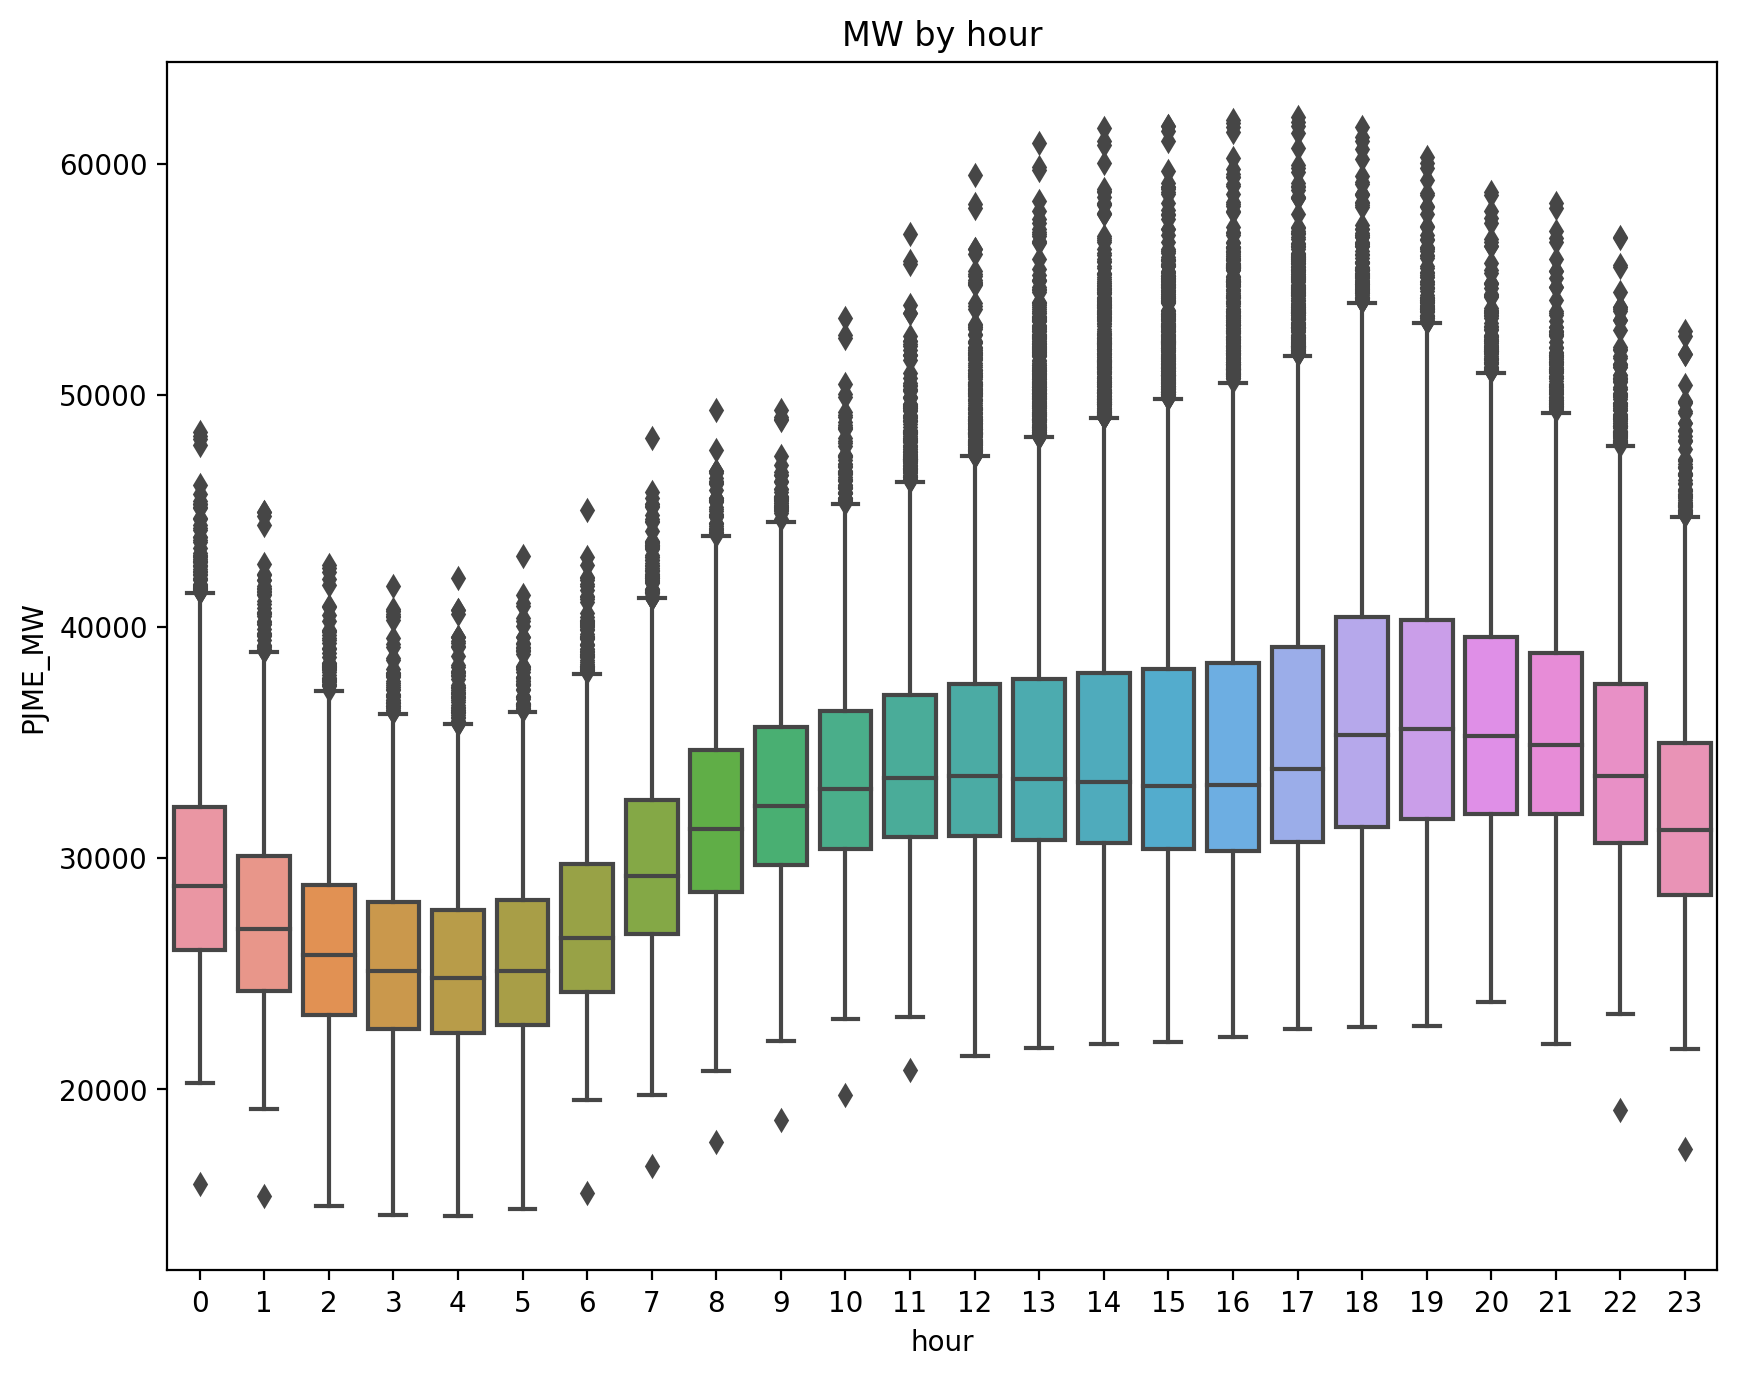

In [12]:
plot('hour','PJME_MW',df)

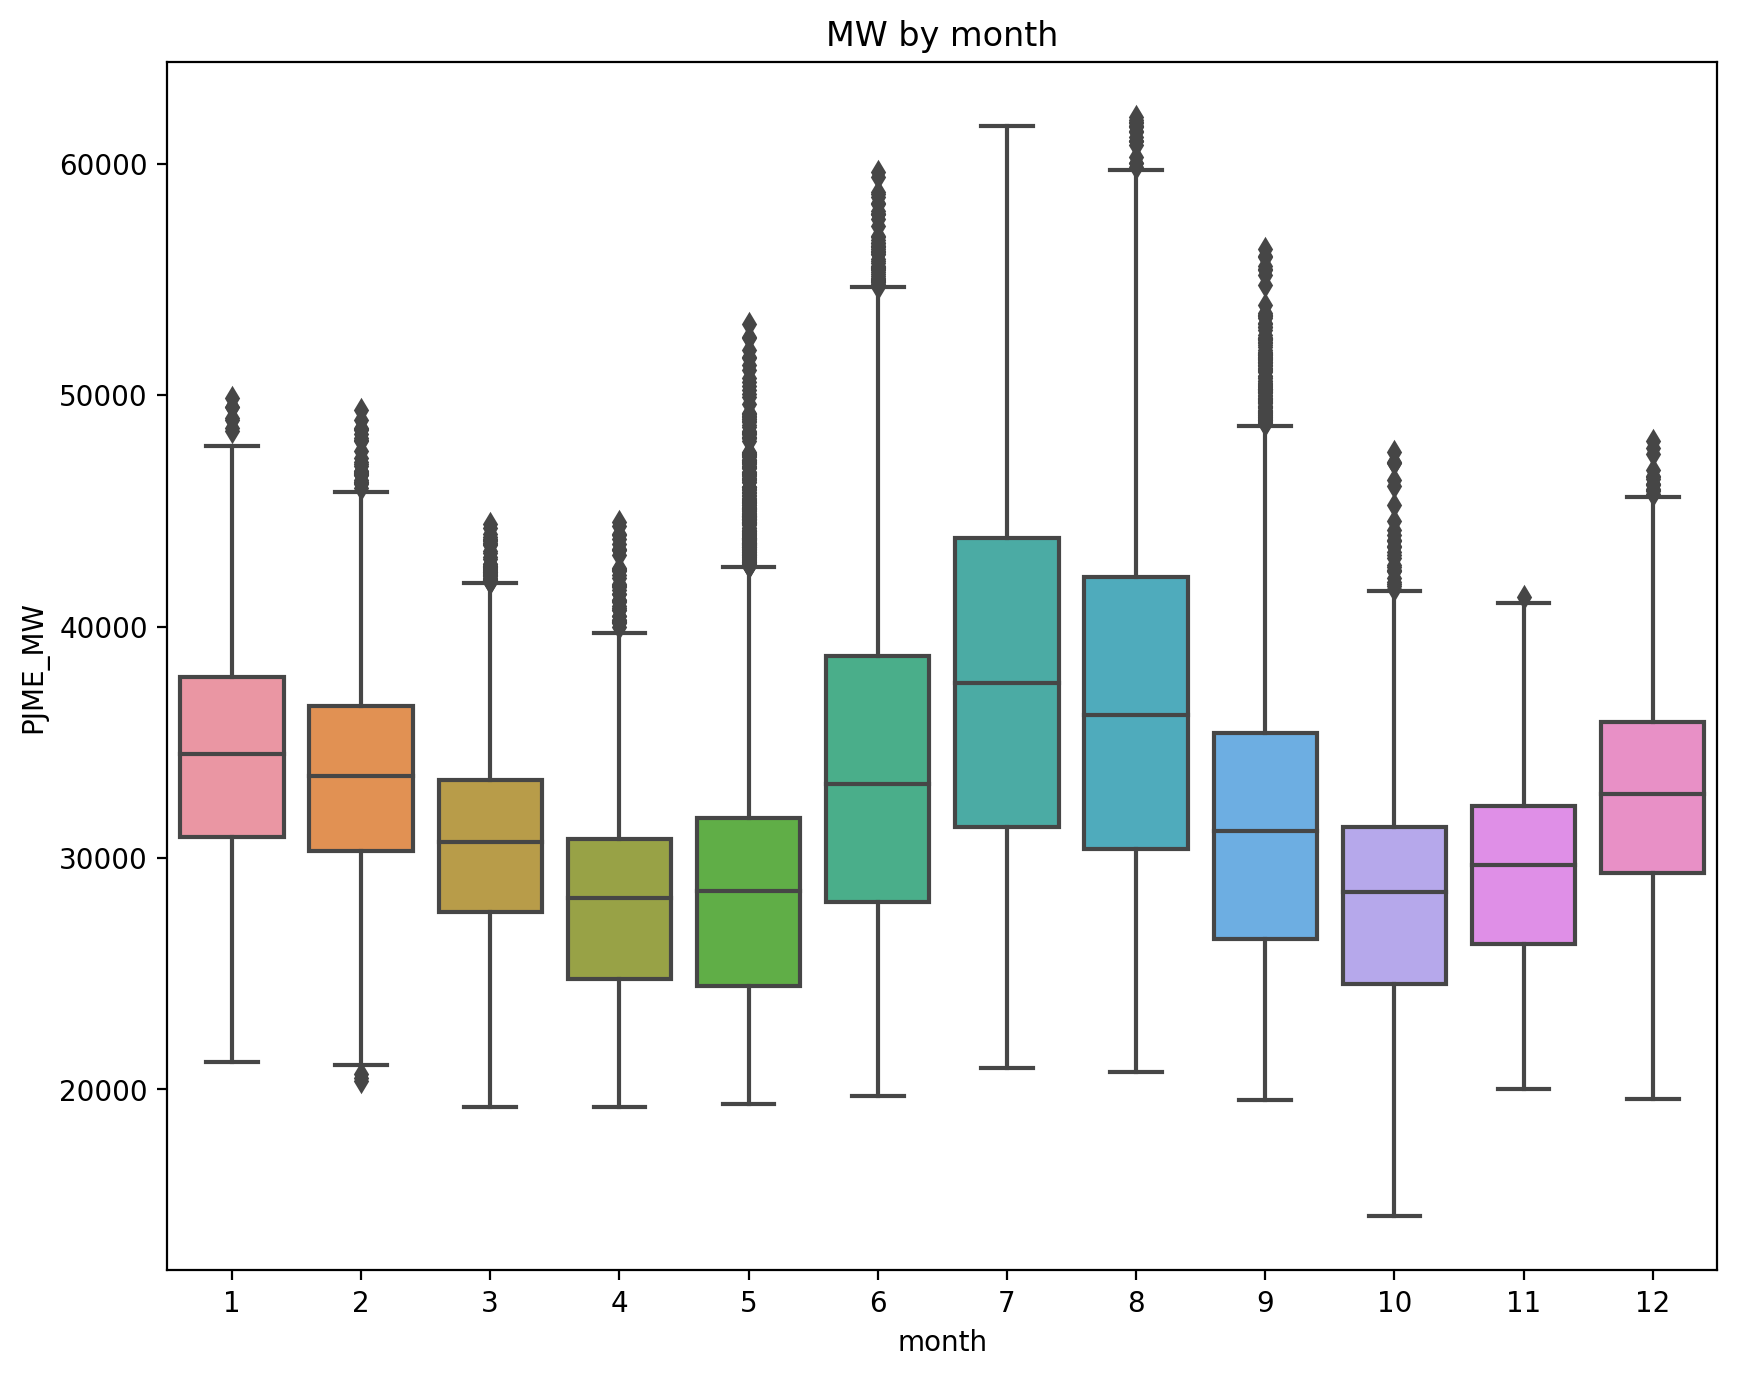

In [13]:
plot('month','PJME_MW',df)

## Creating our model 

In [14]:
train = create_feature(train)
test = create_feature(test)
train

,PJME_MW,hour,day,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365
...,...,...,...,...,...,...,...
2014-01-01 20:00:00,36193.0,20,2,1,1,2014,1
2014-01-01 21:00:00,35601.0,21,2,1,1,2014,1
2014-01-01 22:00:00,34242.0,22,2,1,1,2014,1


In [15]:
df.columns

Index(['PJME_MW', 'hour', 'day', 'quarter', 'month', 'year', 'dayofyear'], dtype='object')

In [16]:
features = ['hour', 'day', 'quarter', 'month', 'year', 'dayofyear']
target = 'PJME_MW'

In [17]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [18]:
reg = xgb.XGBRegressor(n_estimators = 1000,early_stopping_rounds = 50,learning_rate = 0.01)
reg.fit(X_train,y_train,
       eval_set = [(X_train,y_train),(X_test, y_test)],verbose = 100)

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.26256
[100]	validation_0-rmse:12342.13873	validation_1-rmse:11517.61218
[200]	validation_0-rmse:5373.33346	validation_1-rmse:5165.29889
[300]	validation_0-rmse:3375.20923	validation_1-rmse:3829.29864
[400]	validation_0-rmse:2882.55200	validation_1-rmse:3715.10548
[437]	validation_0-rmse:2793.31200	validation_1-rmse:3727.21854


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [19]:
feature_importance = pd.DataFrame(data = reg.feature_importances_ , index = reg.feature_names_in_,columns = ['importance'])

<AxesSubplot:title={'center':'Feature Importance'}>

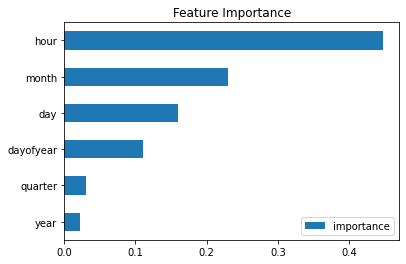

In [20]:
feature_importance.sort_values('importance').plot(kind = 'barh',title = 'Feature Importance')

In [21]:
#df.merge(test[['prediction']],how = 'left',left_index = True,right_index = True)

In [22]:
df.head()

,PJME_MW,hour,day,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365


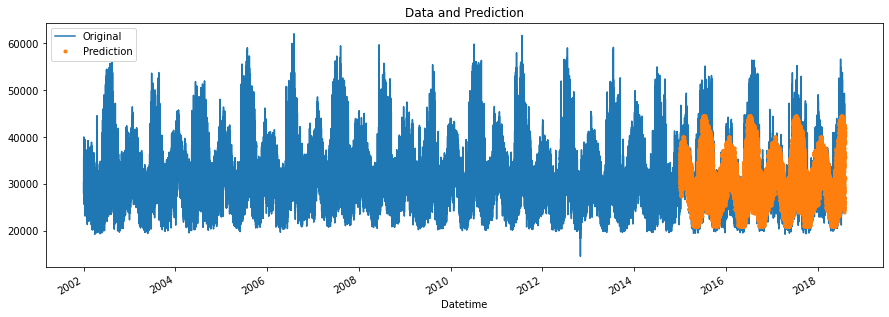

In [23]:
test['prediction'] = reg.predict(X_test)
ax = df[['PJME_MW']].plot(figsize = (15,5))
df = df.merge(test[['prediction']],how = 'left',left_index = True,right_index = True)
df['prediction'].plot(ax=ax, style = '.')
plt.legend(["Original",'Prediction'])
ax.set_title('Data and Prediction')
plt.show()